# TaRGET Project CC ATAC-seq Principal Component Analysis

__Author:__ Bryan Quach  
__Date:__ May 24, 2017

## Objective

### Estimated Analysis Time: <1 day*

Chromatin accessibility profiles are expected to be more similar within tissues than across tissues. Using 50 base pair paired-end ATAC-seq data (sequenced by the UNC High-Throughput Sequencing Facility, i.e., HTSF) from the TaRGET project Collaborative Cross (CC) mice, we set out to evaluate this assumption. If we apply PCA and/or cluster analyis to the data, we hypothesize that chromatin accessibility profiles for samples from the same tissue will group together. Our objective is to test this hypothesis on a finalized set of samples.

**This estimate optimistically assumes that the analysis will be done as shown below without interruption, with an internet connection with high speed data transfer rates, and with all necessary software already installed. Limitations in internet data transfer rates and software installation can significantly increase analysis time.*

## Analysis Outline

The analysis can be roughly divided into the following steps:

* Count matrix generation and normalization
* Exploratory Data Analysis (PCA)

## R Packages

In addition to the base packages, we use the following R packages in this analysis:

* [DESeq2](http://www.bioconductor.org/packages/release/bioc/html/DESeq2.html)
* [dbscan](https://cran.r-project.org/web/packages/dbscan/index.html)

## The Data

The data we are working with are 50 base pair paired-end sequencing reads that have been aligned to CC strain specific genomes then converted to mm9 (C57BL6/J) reference genome coordinate space. From these data, we also have derived open chromatin peak calls in [narrow peak format (NPF)](https://genome.ucsc.edu/FAQ/FAQformat.html#format12) using [F-seq](fureylab.web.unc.edu/software/fseq/) and sorted and shifted BED files. Both of these derived datasets will be used in the analysis. We will be doing analyses that remove the original sequencing results where re-sequencing results are available, so not all the data will be processed. For samples that have been re-sequenced, we will skip processing of the original sequencing data. The data is processed on the UNC Longleaf computing cluster which uses SLURM as its job handling system.

## Count matrix generation and normalization

In order to produce the count matrices we need for PCA, we use the code below on the UNC Longleaf computing cluster. The code produces count matrices for samples in each individual tissue as well as for all the samples across tissues. Because each final count matrix depends on the union set of the samples of interest, we must produce these 4 distinct count matrices before normalization.

In [ ]:
## Do this on Longleaf

#Set working directory
cd /proj/fureylab/data/ATAC/mouse/CC
mkdir coverage_calc
mkdir coverage_calc_all

#Load modules
module load bedtools

#Perform file clean-up as a safety pre-caution
rm CC0*/*/*top50k.npf
rm CC0*/*/*300bpNS.bed
rm CC0*/*/*csaw*bam.bai
rm CC0*/*/*csaw*bam

#Verify excluded sample directories are archived with original directory removed
ls CC018/CC018_Control_LIVER_ATAC_81*
ls CC051/CC051_Control_KIDNEY_ATAC_26*

#Archive if needed
#tar -zcf CC018/CC018_Control_LIVER_ATAC_81.tar.gz CC018/CC018_Control_LIVER_ATAC_81/
#tar -zcf CC051/CC051_Control_KIDNEY_ATAC_26.tar.gz CC051/CC051_Control_KIDNEY_ATAC_26/

#For each sample npf file, retrieve the top 50k open chromatin peaks:
for file in CC0*/*/*npf
do
    echo $file
    sbatch -n 1 --mem=1G --time=1:00:00 --wrap="sort -rnk 7 $file | head -n 50000 > coverage_calc/$(basename ${file/.npf/.top50k.npf})"
    sbatch -n 1 --mem=1G --time=1:00:00 --wrap="sort -rnk 7 $file | head -n 50000 > coverage_calc_all/$(basename ${file/.npf/.top50k.npf})"
done

#Check that each new npf file has 50k peaks
for file in CC0*/*/*npf; do wc -l coverage_calc/$(basename ${file/.npf/.top50k.npf}); done
for file in CC0*/*/*npf; do wc -l coverage_calc_all/$(basename ${file/.npf/.top50k.npf}); done


#Create global and tissue specific peak union sets
cat coverage_calc_all/*top50k.npf > coverage_calc_all/top50k_cat_all.npf
sbatch -n 1 --mem=6G --time=1:00:00 --wrap='sort -k1,1 -k2,2n coverage_calc_all/top50k_cat_all.npf > coverage_calc_all/top50_cat_all_sorted.bed'
sbatch -n 1 --mem=8G --time=1:00:00 --wrap='bedtools merge -i coverage_calc_all/top50_cat_all_sorted.bed -c 1 -o count > coverage_calc_all/top50k_all_union.bed'
sbatch -n 1 --mem=8G --time=1:00:00 --wrap='sort -k1,1 -k2,2n coverage_calc_all/top50k_all_union.bed > coverage_calc_all/top50k_all_union.sorted.bed'

cat coverage_calc/*KIDNEY*top50k.npf > coverage_calc/top50k_cat_kidney.npf
cat coverage_calc/*LUNG*top50k.npf > coverage_calc/top50k_cat_lung.npf
cat coverage_calc/*LIVER*top50k.npf > coverage_calc/top50k_cat_liver.npf
sbatch -n 1 --mem=6G --time=1:00:00 --wrap='sort -k1,1 -k2,2n coverage_calc/top50k_cat_kidney.npf > coverage_calc/top50_cat_kidney_sorted.bed'
sbatch -n 1 --mem=6G --time=1:00:00 --wrap='sort -k1,1 -k2,2n coverage_calc/top50k_cat_lung.npf > coverage_calc/top50_cat_lung_sorted.bed'
sbatch -n 1 --mem=6G --time=1:00:00 --wrap='sort -k1,1 -k2,2n coverage_calc/top50k_cat_liver.npf > coverage_calc/top50_cat_liver_sorted.bed'
sbatch -n 1 --mem=8G --time=1:00:00 --wrap='bedtools merge -i coverage_calc/top50_cat_kidney_sorted.bed -c 1 -o count > coverage_calc/top50k_kidney_union.bed'
sbatch -n 1 --mem=8G --time=1:00:00 --wrap='bedtools merge -i coverage_calc/top50_cat_lung_sorted.bed -c 1 -o count > coverage_calc/top50k_lung_union.bed'
sbatch -n 1 --mem=8G --time=1:00:00 --wrap='bedtools merge -i coverage_calc/top50_cat_liver_sorted.bed -c 1 -o count > coverage_calc/top50k_liver_union.bed'
sbatch -n 1 --mem=8G --time=1:00:00 --wrap='sort -k1,1 -k2,2n coverage_calc/top50k_kidney_union.bed > coverage_calc/top50k_kidney_union.sorted.bed'
sbatch -n 1 --mem=8G --time=1:00:00 --wrap='sort -k1,1 -k2,2n coverage_calc/top50k_liver_union.bed > coverage_calc/top50k_liver_union.sorted.bed'
sbatch -n 1 --mem=8G --time=1:00:00 --wrap='sort -k1,1 -k2,2n coverage_calc/top50k_lung_union.bed > coverage_calc/top50k_lung_union.sorted.bed'

#Create windows
sbatch -n 8 -N 1-1 --mem=48G --time=36:00:00 -o create_windows_all.out --wrap='Rscript /proj/fureylab/code_repository/bquach/create_windows_parallel.R coverage_calc_all/top50k_all_union.sorted.bed coverage_calc_all/300bp_windows_all.bed 8'
sbatch -n 1 -N 1-1 --mem=8G --time=2:00:00 --wrap="bedtools sort -i coverage_calc_all/300bp_windows_all.bed > coverage_calc_all/300bp_windows_all.sorted.bed"

sbatch -n 8 -N 1-1 --mem=48G --time=36:00:00 -o create_windows_kidney.out --wrap='Rscript /proj/fureylab/code_repository/bquach/create_windows_parallel.R coverage_calc/top50k_kidney_union.sorted.bed coverage_calc/300bp_windows_kidney.bed 8'
sbatch -n 8 -N 1-1 --mem=48G --time=36:00:00 -o create_windows_liver.out --wrap='Rscript /proj/fureylab/code_repository/bquach/create_windows_parallel.R coverage_calc/top50k_liver_union.sorted.bed coverage_calc/300bp_windows_liver.bed 8'
sbatch -n 8 -N 1-1 --mem=48G --time=36:00:00 -o create_windows_lung.out --wrap='Rscript /proj/fureylab/code_repository/bquach/create_windows_parallel.R coverage_calc/top50k_lung_union.sorted.bed coverage_calc/300bp_windows_lung.bed 8'
sbatch -n 1 -N 1-1 --mem=8G --time=2:00:00 --wrap="bedtools sort -i coverage_calc/300bp_windows_kidney.bed > coverage_calc/300bp_windows_kidney.sorted.bed"
sbatch -n 1 -N 1-1 --mem=8G --time=2:00:00 --wrap="bedtools sort -i coverage_calc/300bp_windows_liver.bed > coverage_calc/300bp_windows_liver.sorted.bed"
sbatch -n 1 -N 1-1 --mem=8G --time=2:00:00 --wrap="bedtools sort -i coverage_calc/300bp_windows_lung.bed > coverage_calc/300bp_windows_lung.sorted.bed"

#Calculate coverage in windows for each shifted sorted bed file
#BEDTools version must be at least 2.24.0
for file in CC*/*/ss*[0-9].bed
do
    sbatch -n 1 --mem=12G --time=1:00:00 -o coverage_calc_all/$(basename ${file/.bed/.out}) --wrap="bedtools coverage -sorted -counts -b $file -a coverage_calc_all/300bp_windows_all.sorted.bed > coverage_calc_all/$(basename ${file/.bed/.coverage_300bp_all.bed})"
done

for file in CC*/*_KIDNEY*/ss*[0-9].bed
do
    sbatch -n 1 --mem=12G --time=1:00:00 -o coverage_calc/$(basename ${file/.bed/.out}) --wrap="bedtools coverage -sorted -counts -b $file -a coverage_calc/300bp_windows_kidney.sorted.bed > coverage_calc/$(basename ${file/.bed/.coverage_300bp_kidney.bed})"
done

for file in CC*/*_LIVER*/ss*[0-9].bed
do
    sbatch -n 1 --mem=12G --time=1:00:00 -o coverage_calc/$(basename ${file/.bed/.out}) --wrap="bedtools coverage -sorted -counts -b $file -a coverage_calc/300bp_windows_liver.sorted.bed > coverage_calc/$(basename ${file/.bed/.coverage_300bp_liver.bed})"
done

for file in CC*/*_LUNG*/ss*[0-9].bed
do
    sbatch -n 1 --mem=12G --time=1:00:00 -o coverage_calc/$(basename ${file/.bed/.out}) --wrap="bedtools coverage -sorted -counts -b $file -a coverage_calc/300bp_windows_lung.sorted.bed > coverage_calc/$(basename ${file/.bed/.coverage_300bp_lung.bed})"
done

#Get coverage data column and merge
all_cov_files=($(ls coverage_calc_all/ss*.coverage_300bp_all.bed))
kidney_cov_files=($(ls coverage_calc/ss*.coverage_300bp_kidney.bed))
liver_cov_files=($(ls coverage_calc/ss*.coverage_300bp_liver.bed))
lung_cov_files=($(ls coverage_calc/ss*.coverage_300bp_lung.bed))
for i in ${all_cov_files[*]}; do cut -f4,4 $i > coverage_calc_all/$(basename ${i/.bed/.txt}); done
for i in ${kidney_cov_files[*]}; do cut -f4,4 $i > coverage_calc/$(basename ${i/.bed/.txt}); done
for i in ${liver_cov_files[*]}; do cut -f4,4 $i > coverage_calc/$(basename ${i/.bed/.txt}); done
for i in ${lung_cov_files[*]}; do cut -f4,4 $i > coverage_calc/$(basename ${i/.bed/.txt}); done
sbatch -n 1 --mem=8G --time=1:00:00 --wrap="paste coverage_calc_all/ss*.coverage_300bp_all.txt > coverage_calc_all/count_matrix_all.txt"
sbatch -n 1 --mem=8G --time=1:00:00 --wrap="paste coverage_calc/ss*.coverage_300bp_kidney.txt > coverage_calc/count_matrix_kidney.txt"
sbatch -n 1 --mem=8G --time=1:00:00 --wrap="paste coverage_calc/ss*.coverage_300bp_liver.txt > coverage_calc/count_matrix_liver.txt"
sbatch -n 1 --mem=8G --time=1:00:00 --wrap="paste coverage_calc/ss*.coverage_300bp_lung.txt > coverage_calc/count_matrix_lung.txt"

#Combine all count matrix data
awk '{OFS="."} {print $1,$2,$3}' ${all_cov_files[0]} > coverage_calc_all/count_matrix_all_rownames.txt
awk '{OFS="."} {print $1,$2,$3}' ${kidney_cov_files[0]} > coverage_calc/count_matrix_kidney_rownames.txt
awk '{OFS="."} {print $1,$2,$3}' ${liver_cov_files[0]} > coverage_calc/count_matrix_liver_rownames.txt
awk '{OFS="."} {print $1,$2,$3}' ${lung_cov_files[0]} > coverage_calc/count_matrix_lung_rownames.txt
ls coverage_calc_all/ss*.coverage_300bp_all.txt | cut -f2,2 -d'/' | cut -f1,1 -d'.' | awk '{print substr($0, 3)}' > coverage_calc_all/count_matrix_all_colnames.txt
ls coverage_calc/ss*.coverage_300bp_kidney.txt | cut -f2,2 -d'/' | cut -f1,1 -d'.' | awk '{print substr($0, 3)}' > coverage_calc/count_matrix_kidney_colnames.txt
ls coverage_calc/ss*.coverage_300bp_liver.txt | cut -f2,2 -d'/' | cut -f1,1 -d'.' | awk '{print substr($0, 3)}' > coverage_calc/count_matrix_liver_colnames.txt
ls coverage_calc/ss*.coverage_300bp_lung.txt | cut -f2,2 -d'/' | cut -f1,1 -d'.' | awk '{print substr($0, 3)}' > coverage_calc/count_matrix_lung_colnames.txt
cat <(echo "region") coverage_calc_all/count_matrix_all_colnames.txt > coverage_calc_all/count_matrix_all_colnames.txt.tmp
cat <(echo "region") coverage_calc/count_matrix_kidney_colnames.txt > coverage_calc/count_matrix_kidney_colnames.txt.tmp
cat <(echo "region") coverage_calc/count_matrix_liver_colnames.txt > coverage_calc/count_matrix_liver_colnames.txt.tmp
cat <(echo "region") coverage_calc/count_matrix_lung_colnames.txt > coverage_calc/count_matrix_lung_colnames.txt.tmp
mv coverage_calc_all/count_matrix_all_colnames.txt.tmp coverage_calc_all/count_matrix_all_colnames.txt
mv coverage_calc/count_matrix_kidney_colnames.txt.tmp coverage_calc/count_matrix_kidney_colnames.txt
mv coverage_calc/count_matrix_liver_colnames.txt.tmp coverage_calc/count_matrix_liver_colnames.txt
mv coverage_calc/count_matrix_lung_colnames.txt.tmp coverage_calc/count_matrix_lung_colnames.txt
perl -pi -e "s/\n/\t/g" coverage_calc_all/count_matrix_all_colnames.txt
perl -pi -e "s/\n/\t/g" coverage_calc/count_matrix_kidney_colnames.txt
perl -pi -e "s/\n/\t/g" coverage_calc/count_matrix_liver_colnames.txt
perl -pi -e "s/\n/\t/g" coverage_calc/count_matrix_lung_colnames.txt
perl -pi -e "s/\t$//g" coverage_calc_all/count_matrix_all_colnames.txt #remove tag at end of line
perl -pi -e "s/\t$//g" coverage_calc/count_matrix_kidney_colnames.txt #remove tag at end of line
perl -pi -e "s/\t$//g" coverage_calc/count_matrix_liver_colnames.txt #remove tag at end of line
perl -pi -e "s/\t$//g" coverage_calc/count_matrix_lung_colnames.txt #remove tag at end of line
cat coverage_calc_all/count_matrix_all_colnames.txt <(echo "") <(paste coverage_calc_all/count_matrix_all_rownames.txt coverage_calc_all/count_matrix_all.txt) > coverage_calc_all/atac_regions_count_matrix_all.txt
cat coverage_calc/count_matrix_kidney_colnames.txt <(echo "") <(paste coverage_calc/count_matrix_kidney_rownames.txt coverage_calc/count_matrix_kidney.txt) > coverage_calc/atac_regions_count_matrix_kidney.txt
cat coverage_calc/count_matrix_liver_colnames.txt <(echo "") <(paste coverage_calc/count_matrix_liver_rownames.txt coverage_calc/count_matrix_liver.txt) > coverage_calc/atac_regions_count_matrix_liver.txt
cat coverage_calc/count_matrix_lung_colnames.txt <(echo "") <(paste coverage_calc/count_matrix_lung_rownames.txt coverage_calc/count_matrix_lung.txt) > coverage_calc/atac_regions_count_matrix_lung.txt


Since we are doing multiple PCA analyses, we will be creating and normalizing several count matrices that will be used to eventually investigate the following:

* Are all the samples grouping by tissue based on chromatin accessibility profiles?
* Do we see a difference within tissue between exposure groups based on chromatin accessibility profiles?

The reason for multiple matrices is that we want to normalize the subsets of the data independently for each of the analyses in case a subset of samples unrelated to a particular analysis has an overpowering effect on the normalization. Because the dataset we start with is large, we will do the normalizations on the UNC Longleaf compute cluster.

We start with a count matrix that we put through a filtering process to remove the rows that have no or nearly no information about the level of chromatin accessibility. As a simple filtering we apply the following rule: removing rows of the `DESeqDataSet` that have 10 or less counts across all samples. This filtering helps to reduce the contribution of extremely lowly expressed or uninformative regions to the results of PCA.

The data transformation we apply is a [variance-stabilizing transformation](https://en.wikipedia.org/wiki/Variance-stabilizing_transformation) implemented with the DESeq2 `vst` function. It uses a subset of the regions instead of the full set to provide computational speed-ups. We specify that 10000 regions be used to estimate the appropriate transformation function. Once the transformations complete, we save the transformed count matrices to an Rdata file.

In [ ]:
#Do this on the local machine terminal
scp scripts/normalize.R bquach@longleaf.unc.edu:/proj/fureylab/data/ATAC/mouse/CC
scp scripts/pca.R bquach@longleaf.unc.edu:/proj/fureylab/data/ATAC/mouse/CC

#Do this on Longleaf
cd /proj/fureylab/data/ATAC/mouse/CC

#Normalization
sbatch --mem=48G --time=4:00:00 -o normalize_all.out -n 1 --wrap="Rscript normalize.R coverage_calc_all/atac_regions_count_matrix_all.txt coverage_calc_all/atac_regions_vst_matrix_all.rds"
sbatch --mem=20G --time=4:00:00 -o normalize_lung.out -n 1 --wrap="Rscript normalize.R coverage_calc/atac_regions_count_matrix_lung.txt coverage_calc/atac_regions_vst_matrix_lung.rds"
sbatch --mem=20G --time=4:00:00 -o normalize_liver.out -n 1 --wrap="Rscript normalize.R coverage_calc/atac_regions_count_matrix_liver.txt coverage_calc/atac_regions_vst_matrix_liver.rds"
sbatch --mem=20G --time=4:00:00 -o normalize_kidney.out -n 1 --wrap="Rscript normalize.R coverage_calc/atac_regions_count_matrix_kidney.txt coverage_calc/atac_regions_vst_matrix_kidney.rds"

#PCA
sbatch --mem=48G --time=8:00:00 -o pca_all.out -n 1 --wrap="Rscript pca.R coverage_calc_all/atac_regions_vst_matrix_all.rds coverage_calc_all/pca_all.rds"
sbatch --mem=16G --time=4:00:00 -o pca_lung.out -n 1 --wrap="Rscript pca.R coverage_calc/atac_regions_vst_matrix_lung.rds coverage_calc/pca_lung.rds"
sbatch --mem=16G --time=4:00:00 -o pca_liver.out -n 1 --wrap="Rscript pca.R coverage_calc/atac_regions_vst_matrix_liver.rds coverage_calc/pca_liver.rds"
sbatch --mem=16G --time=4:00:00 -o pca_kidney.out -n 1 --wrap="Rscript pca.R coverage_calc/atac_regions_vst_matrix_kidney.rds coverage_calc/pca_kidney.rds"

#Do this on local machine
scp bquach@longleaf.unc.edu:/proj/fureylab/data/ATAC/mouse/CC/coverage_cal*/pca*rds data/
ssh bquach@longleaf.unc.edu "rm -r pca*out normalize*out coverage_calc*"

## Principal Component Analysis and Clustering

We will generate several PCA plots to visually explore several different questions we have about the data. As a reminder, these questions are:

* Are all the samples grouping by tissue based on chromatin accessibility profiles?
* Do we see a difference within tissue between exposure groups based on chromatin accessibility profiles?

To visually explore each of these questions, we will assign geometric or color labels to aid in the comparison of groups. Because the PCA analyses are on a large set of regions, we run all of them on the UNC compute cluster Longleaf and save the PCA results as R data objects.

### Are all the samples grouping by tissue?

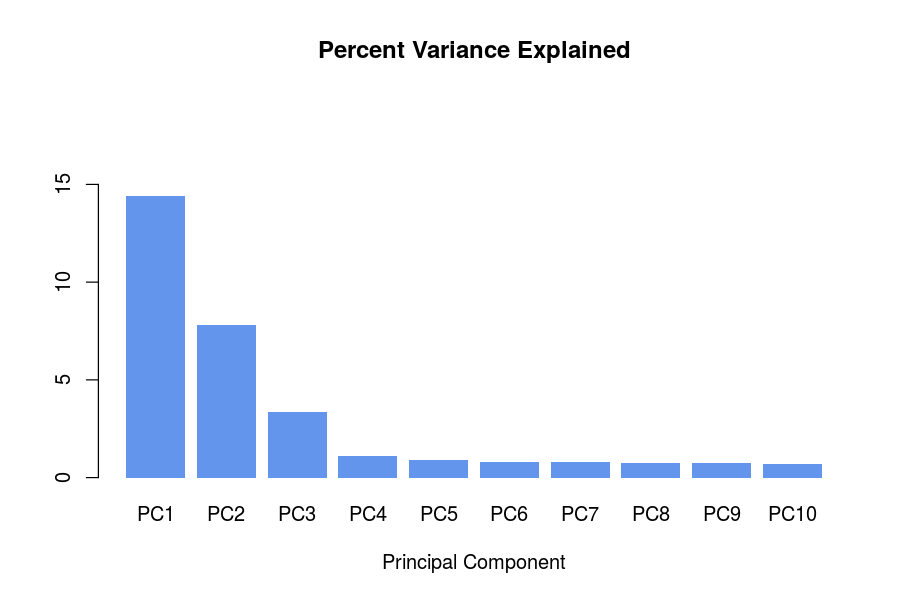

In [3]:
pca.results.all <- readRDS("data/pca_all.rds")

#Get % variance
pca.results <- pca.results.all
dspace <- pca.results$x #transformed dataspace

#Define plot properties
options(repr.plot.width=7.5, repr.plot.height=5)

#Percent of Variance Explained for PCs 1-10
pca.var <- summary(pca.results)
barplot(pca.var$importance[2,1:10]*100, 
        col="cornflowerblue", 
        border=NA, 
        main="Percent Variance Explained", 
        xlab="Principal Component", 
        ylim=c(0, max(pca.var$importance[2,1:10]*100)+5))


Based on the truncated scree plot above, PCs 1, 2, and 3 account for most of the variance in the data, so we will look at those PCs.

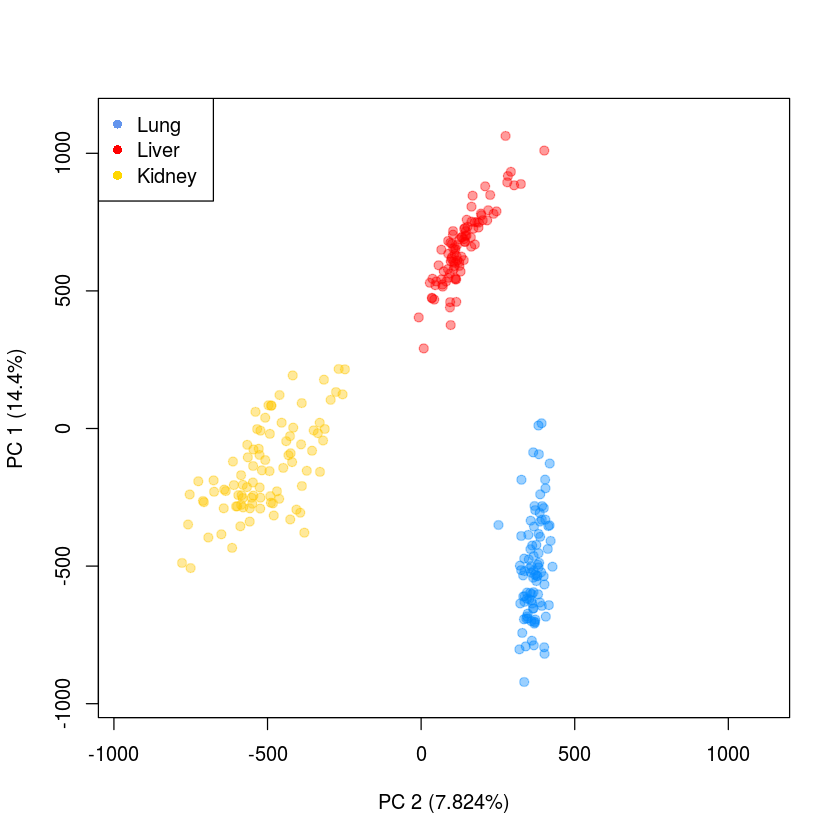

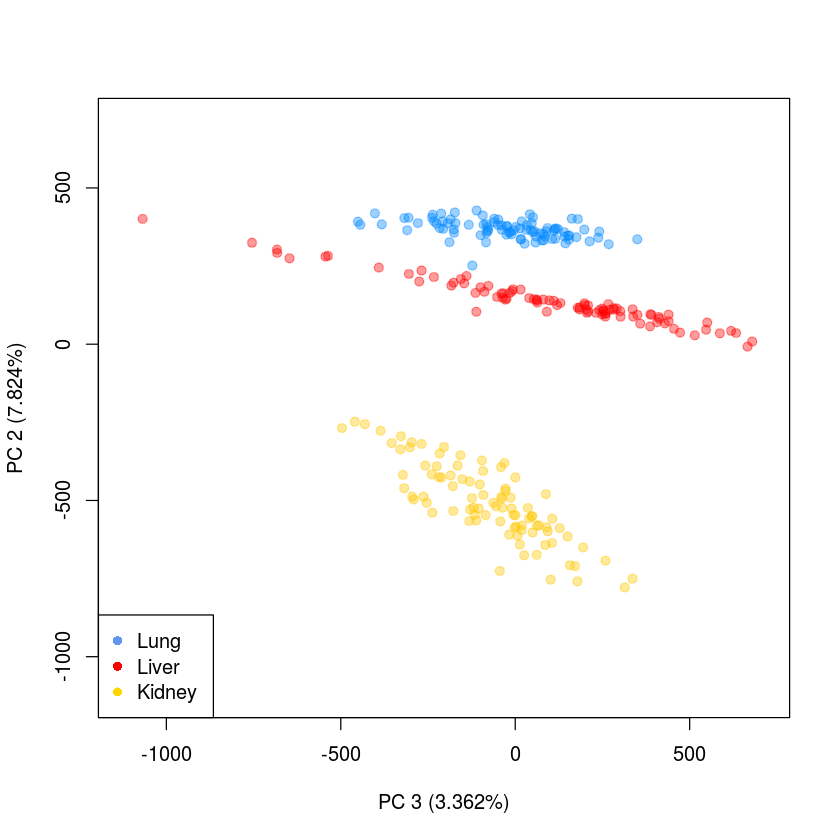

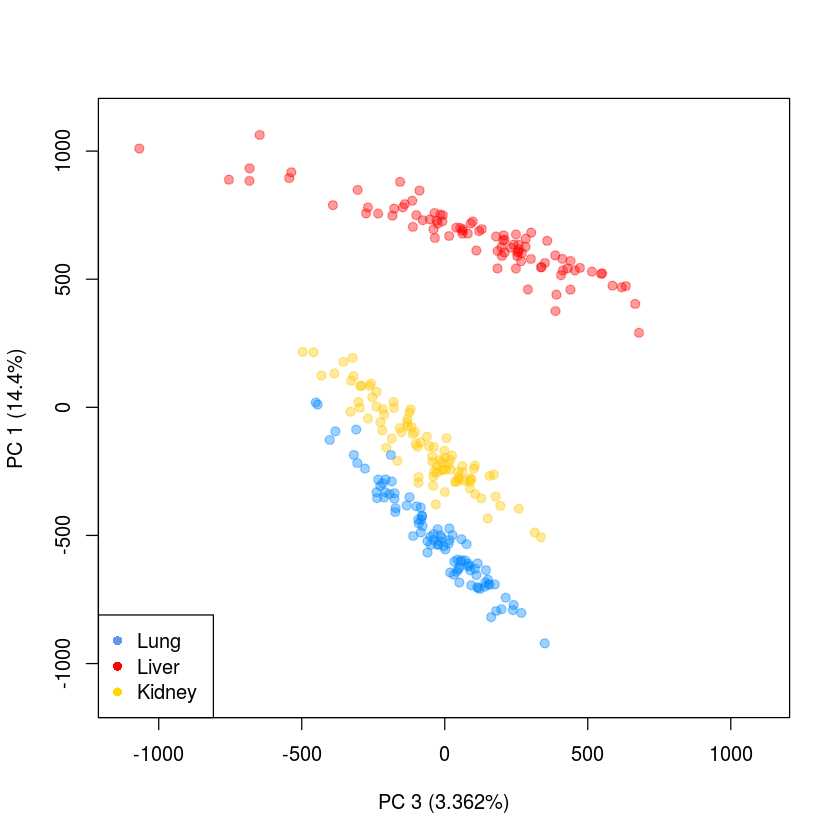

In [4]:
#Define plot properties
pc1.pov <- pca.var$importance[2,1]*100
pc2.pov <- pca.var$importance[2,2]*100
pc3.pov <- pca.var$importance[2,3]*100
options(repr.plot.width=7, repr.plot.height=7)
sample.names <- rownames(dspace)
colors <- rep(NA, length(sample.names))
lung <- grepl("LUNG", sample.names, fixed=T)
kidney <- grepl("KIDNEY", sample.names, fixed=T)
liver <- grepl("LIVER", sample.names, fixed=T)
colors[which(lung)] <- rgb(0,136,255,100, maxColorValue=255) #lightblue
colors[which(liver)] <- rgb(255,0,0,100, maxColorValue=255) #red
colors[which(kidney)] <-  rgb(255,200,0,100, maxColorValue=255) #gold
scale = 1.05
plot.lim1 = c(min(dspace[,1], dspace[,2])*scale, max(dspace[,1], dspace[,2])*scale)
plot.lim2 = c(min(dspace[,3], dspace[,2])*scale, max(dspace[,3], dspace[,2])*scale)
plot.lim3 = c(min(dspace[,3], dspace[,1])*scale, max(dspace[,3], dspace[,1])*scale)
pc1.label = paste("PC 1 (",pc1.pov,"%)",sep="")
pc2.label = paste("PC 2 (",pc2.pov,"%)",sep="")
pc3.label = paste("PC 3 (",pc3.pov,"%)",sep="")
legend.col = c("cornflowerblue", "red", "gold")
legend.lab = c("Lung", "Liver", "Kidney")

#PC1 vs PC2
plot(y=dspace[,1], x=dspace[,2], pch=21, col=colors, bg=colors, 
     xlim=plot.lim1, ylim=plot.lim1,
     ylab=pc1.label, xlab=pc2.label)
legend("topleft", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA)

#PC2 vs PC3
plot(y=dspace[,2], x=dspace[,3], pch=21, col=colors, bg=colors, 
     xlim=plot.lim2, ylim=plot.lim2, 
     ylab=pc2.label, xlab=pc3.label)
legend("bottomleft",
       legend=legend.lab,
       col=legend.col,
       pch=16,
       bg=NA)

#PC1 vs PC3
plot(y=dspace[,1], x=dspace[,3], pch=21, col=colors, bg=colors, 
     xlim=plot.lim3, ylim=plot.lim3, 
     ylab=pc1.label, xlab=pc3.label)
legend("bottomleft", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA)

The above PCA plots show that in general, tissue specific chromatin accessibility generate the most variability between samples

### Do we see a difference between exposure groups within tissue?

If there are consistent drastic trends in chromatin accessibility profile changes between treatment groups, we would expect these to be noticeable by PCA. The plots below assess this expectation.

In [1]:
pca.results.lung <- readRDS("data/pca_lung.rds")
pca.results.liver <- readRDS("data/pca_liver.rds")
pca.results.kidney <- readRDS("data/pca_kidney.rds")

#Get % variance
dspace.liver <- pca.results.liver$x #transformed dataspace
dspace.lung <- pca.results.lung$x #transformed dataspace
dspace.kidney <- pca.results.kidney$x #transformed dataspace

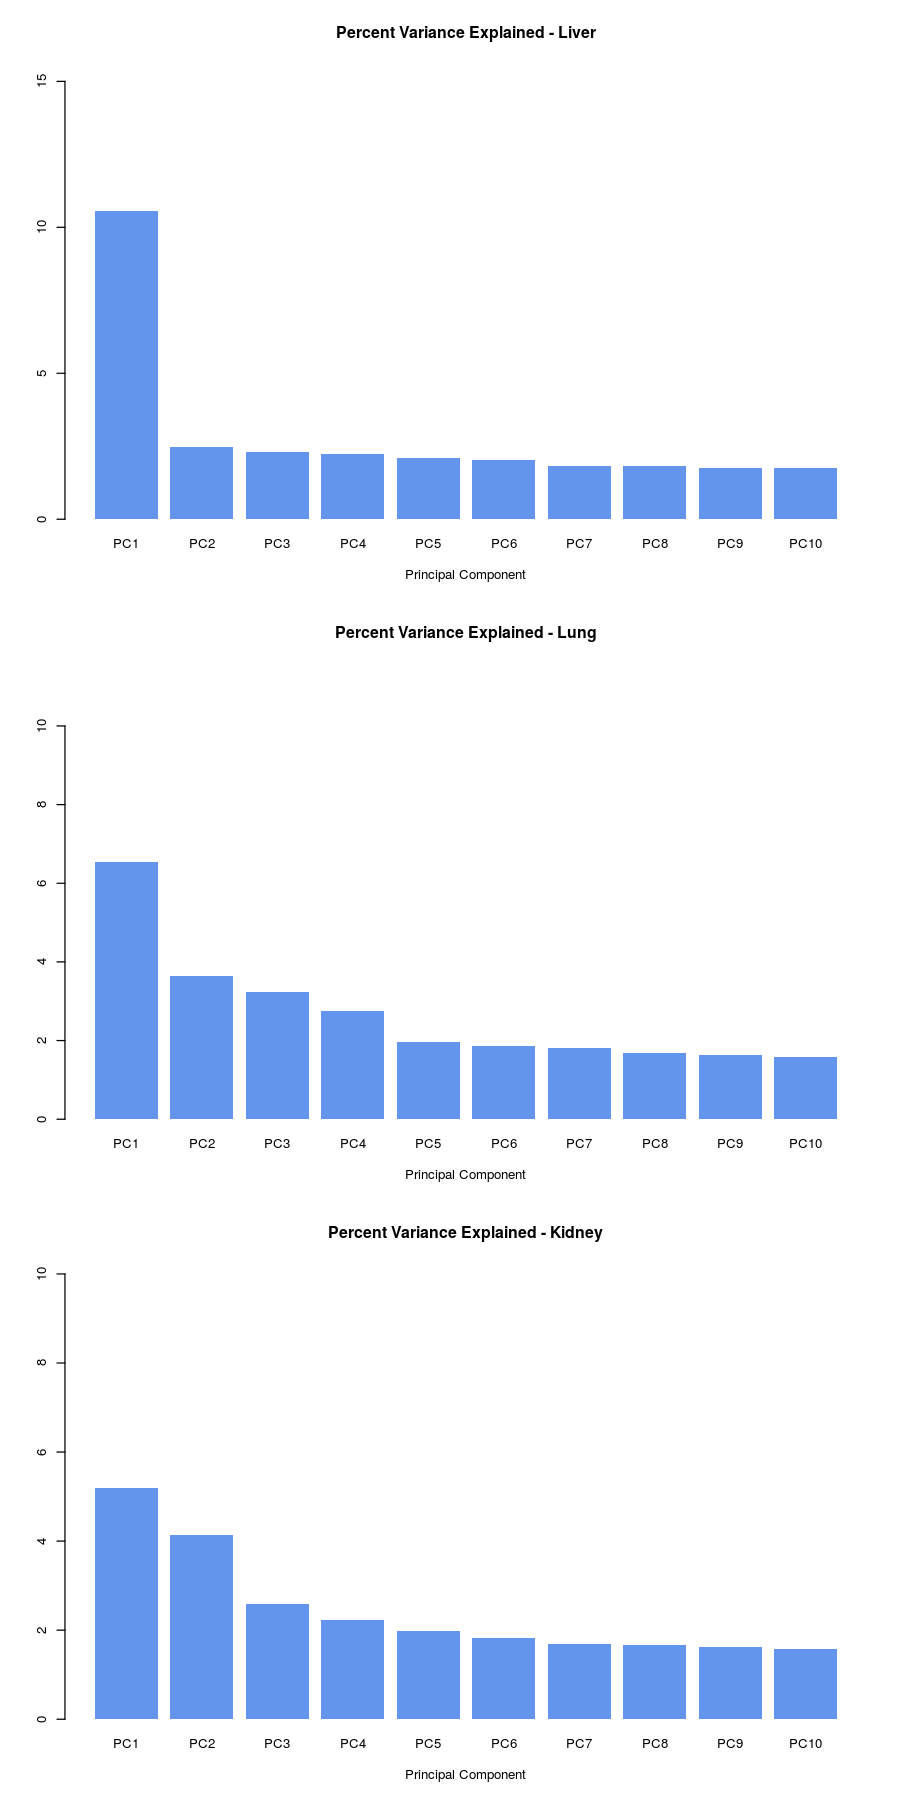

In [2]:
#Define plot properties
options(repr.plot.width=7.5, repr.plot.height=15)

#Percent of Variance Explained for PCs 1-10
par(mfrow=c(3,1))
pca.var.liver <- summary(pca.results.liver)
pca.var.lung <- summary(pca.results.lung)
pca.var.kidney <- summary(pca.results.kidney)
barplot(pca.var.liver$importance[2,1:10]*100, 
        col="cornflowerblue", 
        border=NA, 
        main="Percent Variance Explained - Liver", 
        xlab="Principal Component", 
        ylim=c(0, max(pca.var.liver$importance[2,1:10]*100)+5))
barplot(pca.var.lung$importance[2,1:10]*100, 
        col="cornflowerblue", 
        border=NA, 
        main="Percent Variance Explained - Lung", 
        xlab="Principal Component", 
        ylim=c(0, max(pca.var.lung$importance[2,1:10]*100)+5))
barplot(pca.var.kidney$importance[2,1:10]*100, 
        col="cornflowerblue", 
        border=NA, 
        main="Percent Variance Explained - Kidney", 
        xlab="Principal Component", 
        ylim=c(0, max(pca.var.kidney$importance[2,1:10]*100)+5))

In the truncated scree plots above, the reduction in variance explained with each additional PC is not as drastic as in previous analyses, so we will explore up to PC5.

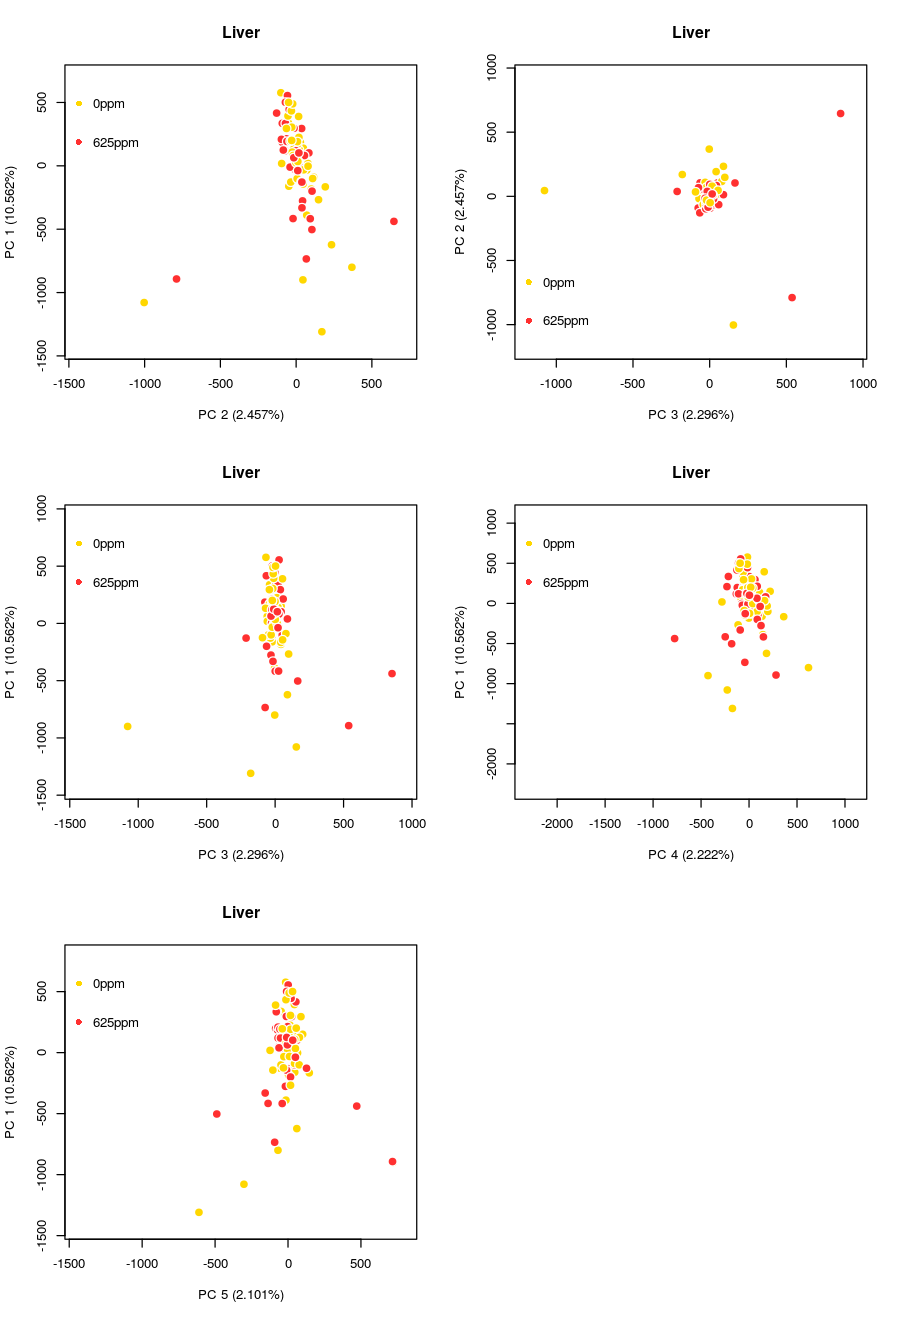

In [5]:
#PCA plots for liver tissue

#Define plot properties
pc1.pov <- pca.var.liver$importance[2,1]*100
pc2.pov <- pca.var.liver$importance[2,2]*100
pc3.pov <- pca.var.liver$importance[2,3]*100
pc4.pov <- pca.var.liver$importance[2,4]*100
pc5.pov <- pca.var.liver$importance[2,5]*100
options(repr.plot.width=7.5, repr.plot.height=11)
sample.names <- rownames(dspace.liver)
colors <- rep(NA, length(sample.names))
colors[grepl("Control", sample.names, fixed=T)] <- "gold"
colors[grepl("BD625", sample.names, fixed=T)] <- "firebrick1"
scale = 1.1
plot.lim1 = c(min(dspace.liver[,1], dspace.liver[,2])*scale, max(dspace.liver[,1], dspace.liver[,2])*scale)
plot.lim2 = c(min(dspace.liver[,3], dspace.liver[,2])*scale, max(dspace.liver[,3], dspace.liver[,2])*scale)
plot.lim3 = c(min(dspace.liver[,1], dspace.liver[,3])*scale, max(dspace.liver[,1], dspace.liver[,3])*scale)
plot.lim4 = c(min(dspace.liver[,1], dspace.liver[,4])*scale*1.6, max(dspace.liver[,1], dspace.liver[,4])*scale*1.6)
plot.lim5 = c(min(dspace.liver[,1], dspace.liver[,5])*scale, max(dspace.liver[,1], dspace.liver[,5])*scale)
pc1.label = paste("PC 1 (",pc1.pov,"%)",sep="")
pc2.label = paste("PC 2 (",pc2.pov,"%)",sep="")
pc3.label = paste("PC 3 (",pc3.pov,"%)",sep="")
pc4.label = paste("PC 4 (",pc4.pov,"%)",sep="")
pc5.label = paste("PC 5 (",pc5.pov,"%)",sep="")
legend.col = c("gold", "firebrick1")
legend.lab = c("0ppm", "625ppm")

par(mfrow=c(3,2))
#PC1 vs PC2
plot(y=dspace.liver[,1], x=dspace.liver[,2], pch=21, col="white", bg=colors, 
     xlim=plot.lim1, ylim=plot.lim1,
     ylab=pc1.label, xlab=pc2.label,
     cex=1.5, 
     main="Liver")
legend("topleft", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")

#PC2 vs PC3
plot(y=dspace.liver[,2], x=dspace.liver[,3], pch=21, col="white", bg=colors, 
     xlim=plot.lim2, ylim=plot.lim2, 
     ylab=pc2.label, xlab=pc3.label,
     cex=1.5, 
     main="Liver")
legend("bottomleft",
       legend=legend.lab,
       col=legend.col,
       pch=16,
       bg=NA, bty="n")

#PC1 vs PC3
plot(y=dspace.liver[,1], x=dspace.liver[,3], pch=21, col="white", bg=colors, 
     xlim=plot.lim3, ylim=plot.lim3, 
     ylab=pc1.label, xlab=pc3.label,
     cex=1.5, 
     main="Liver")
legend("topleft", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")

#PC1 vs PC4
plot(y=dspace.liver[,1], x=dspace.liver[,4], pch=21, col="white", bg=colors, 
     xlim=plot.lim4, ylim=plot.lim4, 
     ylab=pc1.label, xlab=pc4.label,
     cex=1.5, 
     main="Liver")
legend("topleft", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")

#PC1 vs PC5
plot(y=dspace.liver[,1], x=dspace.liver[,5], pch=21, col="white", bg=colors, 
     xlim=plot.lim5, ylim=plot.lim5, 
     ylab=pc1.label, xlab=pc5.label,
     cex=1.5, 
     main="Liver")
legend("topleft", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")

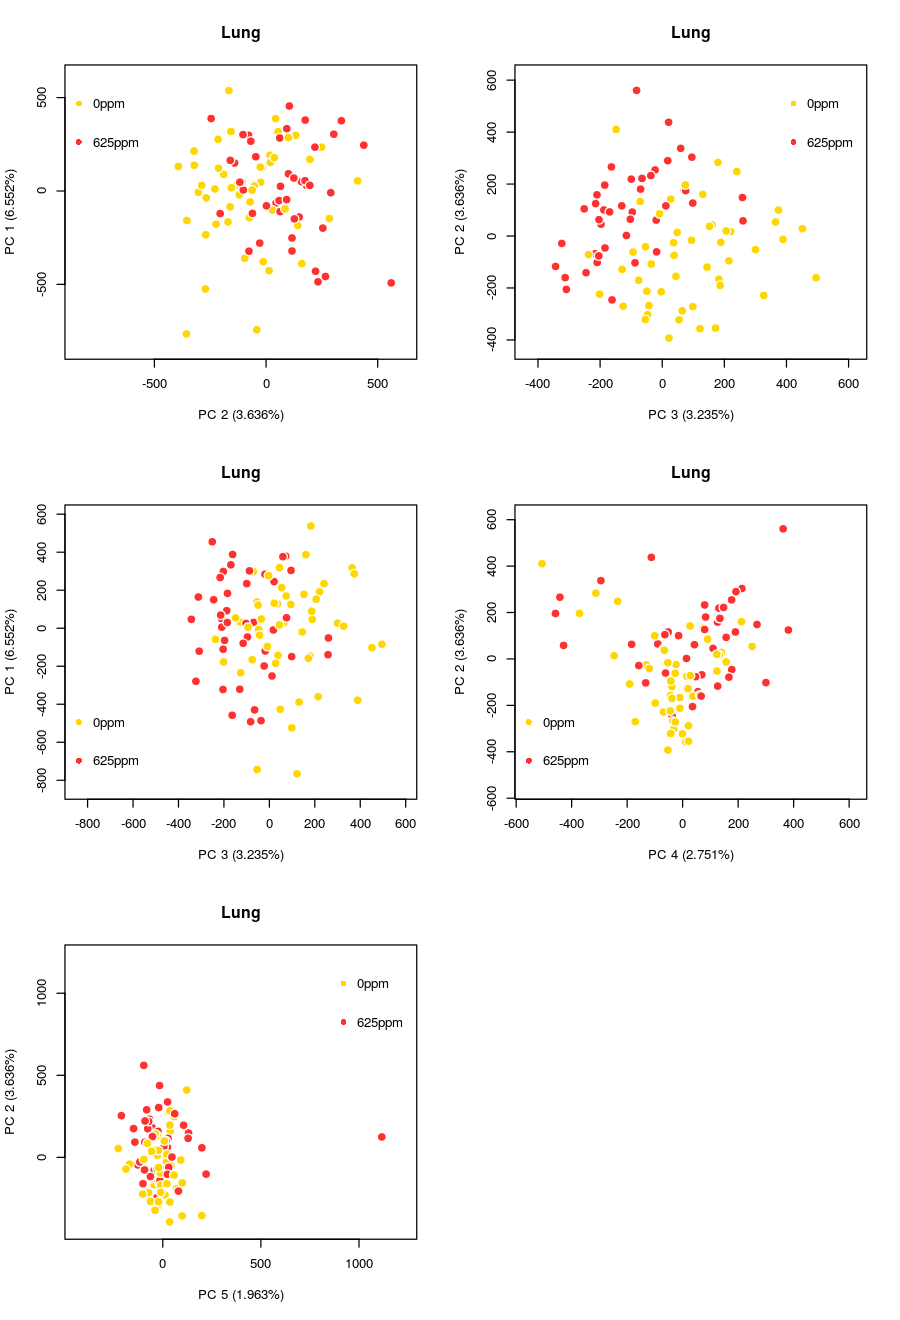

In [9]:
#PCA plots for lung tissue

#Define plot properties
pc1.pov <- pca.var.lung$importance[2,1]*100
pc2.pov <- pca.var.lung$importance[2,2]*100
pc3.pov <- pca.var.lung$importance[2,3]*100
pc4.pov <- pca.var.lung$importance[2,4]*100
pc5.pov <- pca.var.lung$importance[2,5]*100
options(repr.plot.width=7.5, repr.plot.height=11)
sample.names <- rownames(dspace.lung)
colors <- rep(NA, length(sample.names))
colors[grepl("Control", sample.names, fixed=T)] <- "gold"
colors[grepl("BD625", sample.names, fixed=T)] <- "firebrick1"
scale = 1.1
plot.lim1 = c(min(dspace.lung[,1], dspace.lung[,2])*scale, max(dspace.lung[,1], dspace.lung[,2])*scale)
plot.lim2 = c(min(dspace.lung[,3], dspace.lung[,2])*scale, max(dspace.lung[,3], dspace.lung[,2])*scale)
plot.lim3 = c(min(dspace.lung[,1], dspace.lung[,3])*scale, max(dspace.lung[,1], dspace.lung[,3])*scale)
plot.lim4 = c(min(dspace.lung[,2], dspace.lung[,4])*scale, max(dspace.lung[,2], dspace.lung[,4])*scale)
plot.lim5 = c(min(dspace.lung[,2], dspace.lung[,5])*scale, max(dspace.lung[,2], dspace.lung[,5])*scale)
pc1.label = paste("PC 1 (",pc1.pov,"%)",sep="")
pc2.label = paste("PC 2 (",pc2.pov,"%)",sep="")
pc3.label = paste("PC 3 (",pc3.pov,"%)",sep="")
pc4.label = paste("PC 4 (",pc4.pov,"%)",sep="")
pc5.label = paste("PC 5 (",pc5.pov,"%)",sep="")
legend.col = c("gold", "firebrick1")
legend.lab = c("0ppm", "625ppm")

par(mfrow=c(3,2))
#PC1 vs PC2
plot(y=dspace.lung[,1], x=dspace.lung[,2], pch=21, col="white", bg=colors, 
     xlim=plot.lim1, ylim=plot.lim1,
     ylab=pc1.label, xlab=pc2.label,
     cex=1.5,
     main="Lung")
legend("topleft", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")

#PC2 vs PC3
plot(y=dspace.lung[,2], x=dspace.lung[,3], pch=21, col="white", bg=colors, 
     xlim=plot.lim2, ylim=plot.lim2, 
     ylab=pc2.label, xlab=pc3.label,
     cex=1.5,
     main="Lung")
legend("topright",
       legend=legend.lab,
       col=legend.col,
       pch=16,
       bg=NA, bty="n")

#PC1 vs PC3
plot(y=dspace.lung[,1], x=dspace.lung[,3], pch=21, col="white", bg=colors, 
     xlim=plot.lim3, ylim=plot.lim3, 
     ylab=pc1.label, xlab=pc3.label,
     cex=1.5,
     main="Lung")
legend("bottomleft", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")

#PC2 vs PC4
plot(y=dspace.lung[,2], x=dspace.lung[,4], pch=21, col="white", bg=colors, 
     xlim=plot.lim4, ylim=plot.lim4, 
     ylab=pc2.label, xlab=pc4.label,
     cex=1.5,
     main="Lung")
legend("bottomleft", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")

#PC2 vs PC5
plot(y=dspace.lung[,2], x=dspace.lung[,5], pch=21, col="white", bg=colors, 
     xlim=plot.lim5, ylim=plot.lim5, 
     ylab=pc2.label, xlab=pc5.label,
     cex=1.5,
     main="Lung")
legend("topright", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")



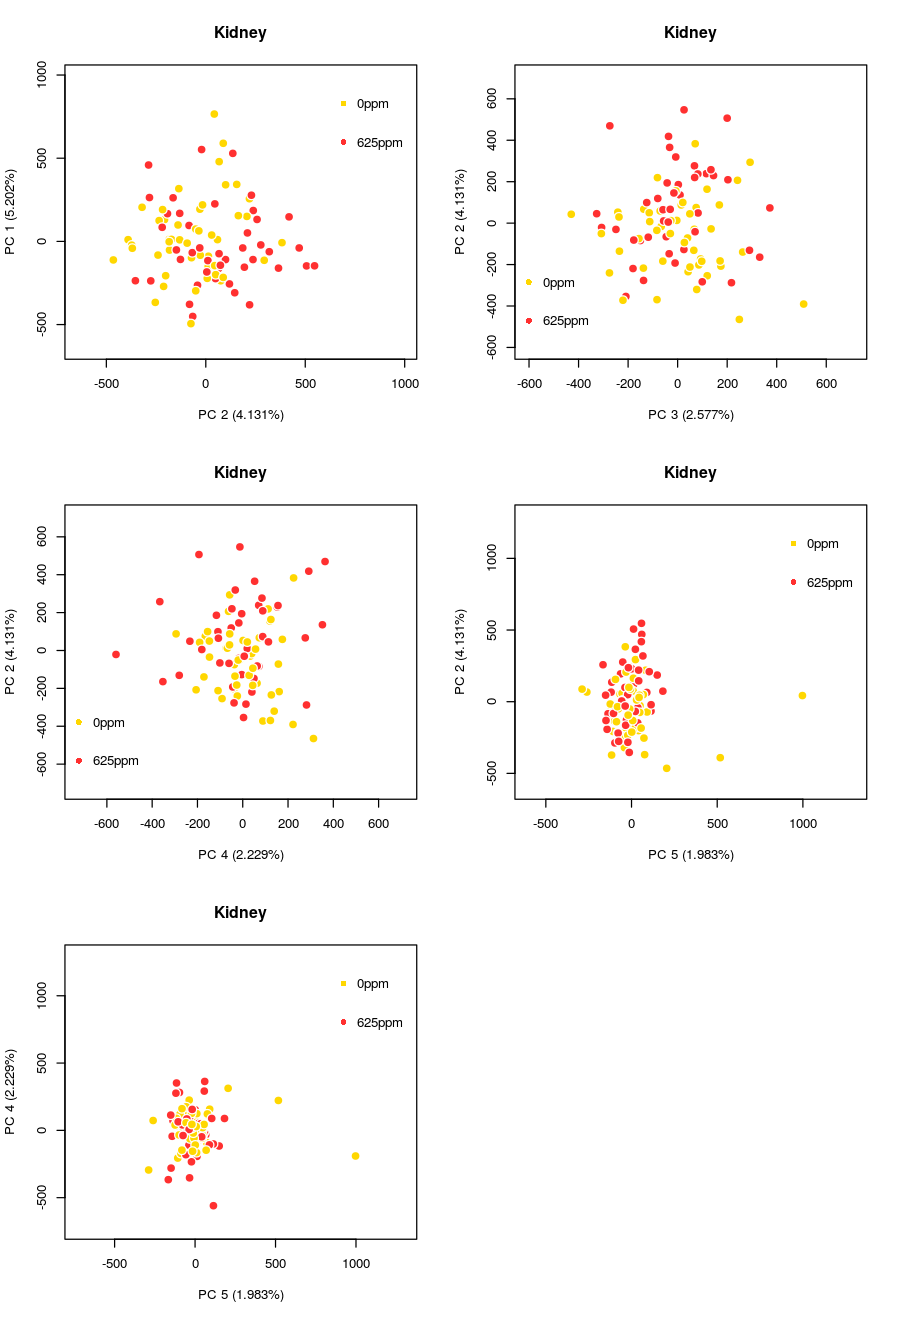

In [10]:
#PCA plots for kidney tissue

#Define plot properties
pc1.pov <- pca.var.kidney$importance[2,1]*100
pc2.pov <- pca.var.kidney$importance[2,2]*100
pc3.pov <- pca.var.kidney$importance[2,3]*100
pc4.pov <- pca.var.kidney$importance[2,4]*100
pc5.pov <- pca.var.kidney$importance[2,5]*100
options(repr.plot.width=7.5, repr.plot.height=11)
sample.names <- rownames(dspace.kidney)
colors <- rep(NA, length(sample.names))
colors[grepl("Control", sample.names, fixed=T)] <- "gold"
colors[grepl("BD625", sample.names, fixed=T)] <- "firebrick1"
scale = 1.3
plot.lim1 = c(min(dspace.kidney[,1], dspace.kidney[,2])*scale, max(dspace.kidney[,1], dspace.kidney[,2])*scale)
plot.lim2 = c(min(dspace.kidney[,3], dspace.kidney[,2])*scale, max(dspace.kidney[,3], dspace.kidney[,2])*scale)
plot.lim3 = c(min(dspace.kidney[,2], dspace.kidney[,4])*scale, max(dspace.kidney[,2], dspace.kidney[,4])*scale)
plot.lim4 = c(min(dspace.kidney[,2], dspace.kidney[,5])*scale, max(dspace.kidney[,2], dspace.kidney[,5])*scale)
plot.lim5 = c(min(dspace.kidney[,4], dspace.kidney[,5])*scale, max(dspace.kidney[,4], dspace.kidney[,5])*scale)
pc1.label = paste("PC 1 (",pc1.pov,"%)",sep="")
pc2.label = paste("PC 2 (",pc2.pov,"%)",sep="")
pc3.label = paste("PC 3 (",pc3.pov,"%)",sep="")
pc4.label = paste("PC 4 (",pc4.pov,"%)",sep="")
pc5.label = paste("PC 5 (",pc5.pov,"%)",sep="")
legend.col = c("gold", "firebrick1")
legend.lab = c("0ppm", "625ppm")

par(mfrow=c(3,2))
#PC1 vs PC2
plot(y=dspace.kidney[,1], x=dspace.kidney[,2], pch=21, col="white", bg=colors, 
     xlim=plot.lim1, ylim=plot.lim1,
     ylab=pc1.label, xlab=pc2.label,
     cex=1.5,
     main="Kidney")
legend("topright", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")

#PC2 vs PC3
plot(y=dspace.kidney[,2], x=dspace.kidney[,3], pch=21, col="white", bg=colors, 
     xlim=plot.lim2, ylim=plot.lim2, 
     ylab=pc2.label, xlab=pc3.label,
     cex=1.5,
     main="Kidney")
legend("bottomleft",
       legend=legend.lab,
       col=legend.col,
       pch=16,
       bg=NA, bty="n")

#PC2 vs PC4
plot(y=dspace.kidney[,2], x=dspace.kidney[,4], pch=21, col="white", bg=colors, 
     xlim=plot.lim3, ylim=plot.lim3, 
     ylab=pc2.label, xlab=pc4.label,
     cex=1.5,
     main="Kidney")
legend("bottomleft", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")

#PC2 vs PC5
plot(y=dspace.kidney[,2], x=dspace.kidney[,5], pch=21, col="white", bg=colors, 
     xlim=plot.lim4, ylim=plot.lim4, 
     ylab=pc2.label, xlab=pc5.label,
     cex=1.5,
     main="Kidney")
legend("topright", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")

#PC4 vs PC5
plot(y=dspace.kidney[,4], x=dspace.kidney[,5], pch=21, col="white", bg=colors, 
     xlim=plot.lim5, ylim=plot.lim5, 
     ylab=pc4.label, xlab=pc5.label,
     cex=1.5,
     main="Kidney")
legend("topright", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")
